<a href="https://colab.research.google.com/github/lokeshpara/samplegit/blob/S7/eva_session7_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import libraries


In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
import numpy as np

## Train_loader and Test_loader

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)



# train dataloader
train_loader = torch.utils.data.DataLoader(trainset, **dataloader_args)



# test dataloader
test_loader = torch.utils.data.DataLoader(testset, **dataloader_args)



classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CUDA Available? True


plane   dog  deer  deer


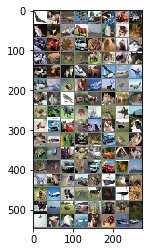

In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## model 

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        dropout_value=0.1


        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(32),
                                   nn.Dropout(dropout_value))
            
                                                                                   # Input: 32x32x3 | Output: 32x32x32 | RF: 3x3



        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(32),
                                   nn.Dropout(dropout_value))
           
                                                                                   # Input: 32x32x32 | Output: 32x32x32 | RF: 5x5



        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2, dilation=2),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(64),
                                   nn.Dropout(dropout_value))
        
                                                                                   # Input: 32x32x32 | Output: 32x32x32 | RF: 9x9



        self.pool1 = nn.MaxPool2d(2, 2)                                            # Input: 32x32x32 | Output: 16x16x32 | RF: 10x10


        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=2, dilation=2),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(64),
                                   nn.Dropout(dropout_value) )
          
           
                                                                                   # Input: 16x16x32 | Output: 16x16x64 | RF: 18x18



        self.conv5 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=2, dilation=2),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(64),
                                   nn.Dropout(dropout_value)) 
            
            
                                                                                   # Input: 16x16x64 | Output: 16x16x64 | RF: 26x26


        #depthwise convolution
        self.conv6 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3,padding=1,groups=64),
                                   nn.Conv2d(in_channels=128,out_channels=128,kernel_size=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(128),
                                   nn.Dropout(dropout_value))
                                                                                   # Input: 16x16x64 | Output: 16x16x64 | RF: 30x30



        self.pool2 = nn.MaxPool2d(2, 2)                                            # Input: 16x16x64 | Output: 8x8x64 | RF: 32x32

        #depthwise convolution
        self.conv7 = nn.Sequential( nn.Conv2d(in_channels=128, out_channels=128,kernel_size=3,padding=1,groups=128),           
                                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(128),
                                    nn.Dropout(dropout_value))
                                                                                   # Input: 8x8x64 | Output: 8x8x128 | RF: 40x40

        # dilation
        self.conv8 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=2, dilation=2),            
                                   nn.ReLU(),
                                   nn.BatchNorm2d(128),
                                   nn.Dropout(dropout_value))
                                                                                  # Input: 8x8x128 | Output: 8x8x128 | RF: 56x56


        self.pool3 = nn.MaxPool2d(2, 2)                                           # Input: 8x8x128 | Output: 4x4x128 | RF: 60x60


        self.gap =nn.AvgPool2d(kernel_size=4)
                                                                                  # Input: 4x4x128 | Output: 1x1x128 | RF: 84x84


        self.fc = nn.Linear(128, 10)                                              # Input: 1x1x128 | Output: 1x1x10 | RF: 84x84



    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool1(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.pool2(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.pool3(x)
        x = self.gap(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return x

In [5]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,248
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,496
             ReLU-10           [-1, 64, 32, 32]               0
      BatchNorm2d-11           [-1, 64, 32, 32]             128
          Dropout-12           [-1, 64, 32, 32]               0
        MaxPool2d-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

In [0]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, loss_func, epoch, l1=False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = loss_func(y_pred, target)

    # L1 regularization
    if l1 == True:
      reg_loss = 0
      for param in model.parameters():
        reg_loss += torch.sum(abs(param))
      factor = 0.000002
      loss += factor * reg_loss

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, loss_func):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_func(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Define a Loss function and optimizer
## ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
## Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [7]:

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=0)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
loss_func=nn.CrossEntropyLoss()
 
for epoch in range(10):
    print("Epoch:", epoch)
    train(model, device, train_loader, optimizer, loss_func, epoch, l1=False)
    # scheduler.step()
    test(model, device, test_loader, nn.CrossEntropyLoss(reduction='sum'))

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 0


Loss=0.9217429161071777 Batch_id=390 Accuracy=49.17: 100%|██████████| 391/391 [00:15<00:00, 25.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.2509, Accuracy: 5675/10000 (56.75%)

Epoch: 1


Loss=0.7765200138092041 Batch_id=390 Accuracy=68.45: 100%|██████████| 391/391 [00:15<00:00, 25.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8410, Accuracy: 7035/10000 (70.35%)

Epoch: 2


Loss=0.701512336730957 Batch_id=390 Accuracy=75.48: 100%|██████████| 391/391 [00:15<00:00, 25.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8243, Accuracy: 7184/10000 (71.84%)

Epoch: 3


Loss=0.6405920386314392 Batch_id=390 Accuracy=79.17: 100%|██████████| 391/391 [00:15<00:00, 25.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6557, Accuracy: 7703/10000 (77.03%)

Epoch: 4


Loss=0.5724517703056335 Batch_id=390 Accuracy=81.55: 100%|██████████| 391/391 [00:15<00:00, 25.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5939, Accuracy: 7974/10000 (79.74%)

Epoch: 5


Loss=0.28072571754455566 Batch_id=390 Accuracy=83.52: 100%|██████████| 391/391 [00:15<00:00, 25.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5620, Accuracy: 8054/10000 (80.54%)

Epoch: 6


Loss=0.510184645652771 Batch_id=390 Accuracy=84.65: 100%|██████████| 391/391 [00:15<00:00, 25.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5369, Accuracy: 8142/10000 (81.42%)

Epoch: 7


Loss=0.3455773591995239 Batch_id=390 Accuracy=86.23: 100%|██████████| 391/391 [00:15<00:00, 26.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5164, Accuracy: 8240/10000 (82.40%)

Epoch: 8


Loss=0.37118658423423767 Batch_id=390 Accuracy=87.37: 100%|██████████| 391/391 [00:15<00:00, 25.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5578, Accuracy: 8092/10000 (80.92%)

Epoch: 9


Loss=0.4876798689365387 Batch_id=390 Accuracy=88.35: 100%|██████████| 391/391 [00:15<00:00, 25.61it/s]



Test set: Average loss: 0.5539, Accuracy: 8156/10000 (81.56%)



Text(0.5, 1.0, 'Test Accuracy')

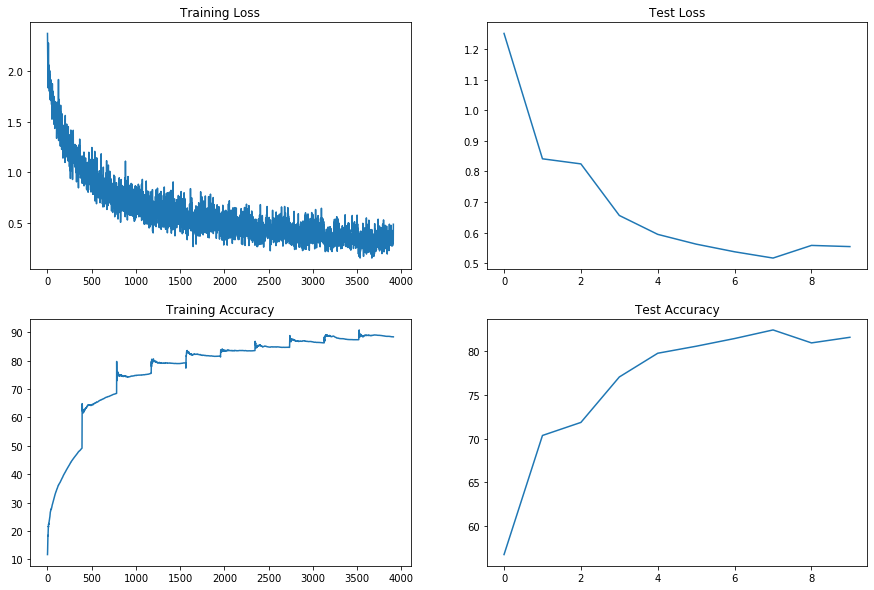

In [12]:

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")